In [1]:
from __future__ import division
from numpy.random import random, randint
from random import choice
import numpy as np
from numpy import dot, array
from playxo import *
from stratagies import *
# from testindata import inputs, goal
from awesomeai import frontmatrix, frontoffset, backmatrix, backoffset
import matplotlib.pylab as plt
from oneturntesting import inputs, goal
%matplotlib inline
np.random.seed(1337)

/Users/zavidan/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [152]:
# Activation Functions
def rectified_linear(x):
    return np.maximum(0.0, x)

def tanh_sigmoid(x):
    return np.tanh(x)

def fast_sigmoid(x):
    return x / (1 + np.absolute(x))

def maxout_sigmoid(x):
    return np.maximum(0.0, np.minimum(x, 1.0))

def random_sign():
    return choice([1,-1])

def linear(x):
    return x


class NNLayer(object):
    def __init__(self, matrix, offset, activation=rectified_linear):
        self.matrix = np.array(matrix)
        self.offset = np.array(offset)
        self.activation = activation
        
    def __repr__(self):
        return "NNLayer(matrix={}, offset={}, activation={})".format(self.matrix.__repr__(), self.offset.__repr__(), self.activation)
    
    def calcout(self, invector):
        offset = [self.offset]*len(invector)
        line = dot(invector, self.matrix) + self.offset
        return self.activation(line)
    
    @classmethod
    def random(cls, inwidth, outwidth, weightrange=0.5, activation=rectified_linear):
        offset = (np.random.rand(1,outwidth) * 2 - 1) * weightrange
        weights = (np.random.rand(inwidth, outwidth) * 2 - 1) * weightrange
        return cls(weights, offset, activation=activation)
    
class NNLayer_Learn(NNLayer):
    def __init__(self, matrix, offset, activation=rectified_linear, maxdelta=None):
        super(NNLayer_Learn, self).__init__(matrix, offset, activation=activation)
        if maxdelta is None:
            self.maxdelta = random() * 2 - 1
        else:
            self.maxdelta = 0
            self.maxdelta += maxdelta
        self.columns = len(self.matrix[0])
        self.rows = len(self.matrix)
    
    def __repr__(self):
        return "NNLayer_Learn(matrix={}, offset={}, activation={}, maxdelta={})".format(self.matrix.__repr__(), self.offset.__repr__(), self.activation, self.maxdelta)

    def mutate(self,mutaterate=0.33):
        maxdelta  = 0.001
        # find change in max delta
        maxdelta = self.error/10
        # maxdelta changes up or down
        #self.maxdelta += dmaxdelta*random_sign()
        size = np.size(self.matrix)
        # make a copy of the matrix
        nmatrix = np.copy(self.matrix)
        noffset = np.copy(self.offset)
        
        mutatematrix = np.random.binomial(1,mutaterate,(self.rows,self.columns))
        delta = (np.random.rand(self.rows,self.columns)*2-1) * self.maxdelta
        deltamatrix = mutatematrix * delta
        nmatrix += deltamatrix
        
        mutateoffset = np.random.binomial(1,mutaterate,(1,self.columns))
        delta = (np.random.rand(1,self.columns)*2-1) * self.maxdelta
        deltaoffset = delta * mutateoffset
        noffset += deltaoffset
        
        return self.__class__(nmatrix, noffset, activation=self.activation, maxdelta=self.maxdelta)
    
    def breed(self, other, prob=0.33):
        proportionself = np.random.binomial(1,prob,(self.rows,self.columns))
        selfportion = proportionself*self.matrix
        proportionother = (proportionself* -1) + 1
        otherportion = proportionother*other.matrix
        nmatrix = selfportion+otherportion
        
        proportionself = np.random.binomial(1,prob,(1,self.columns))
        selfportion = proportionself*self.offset
        proportionother = (proportionself* -1) + 1
        otherportion = proportionother*other.offset
        noffset = selfportion+otherportion
        return self.__class__(nmatrix, noffset, activation=self.activation, maxdelta=self.maxdelta)


class Perceptron(NNLayer_Learn):
    def __repr__(self):
        return "Perceptron(matrix={}, offset={}, activation={}, maxdelta={})".format(self.matrix.__repr__(), self.offset.__repr__(), self.activation, self.maxdelta)
    
    def calcerror(self, inputs, goal):
        output = self.calcout(inputs)
        error = np.array(goal) - output
        average = np.sqrt((error**2).mean())
        self.error = average
        return average
    
    def graddecent(self, inputs, goal, learningrate=0.01, error=None, see=False):
        if error is None:
            output = self.calcout(inputs)
            error = np.array(goal) - output
        inputs = np.array(inputs).T
        deltamatrix = dot(inputs,error)*learningrate
        deltaoffset = error*learningrate
        nperceptron = self.copy()
        if see:
            print nperceptron.matrix
            print 
            print deltamatrix
            print 
            print dot(inputs,error)*learningrate
        nperceptron.matrix += deltamatrix
        nperceptron.offset += deltaoffset
        return nperceptron, error
    
    def calcangle(self, inputs, goal):
        output = self.calcout(inputs)
        normalgoals = np.array([go/np.sum(np.sqrt(go**2)) for go in goal])
        normalouts = np.array([out/np.sum(np.sqrt(out**2)) for out in output])
        angles = np.array([dot(out, goal.T) for out, goal in zip(normalouts, normalgoals)])
        aangles = angles.mean()
        self.angle = aangles
        return aangles
    
    def copy(self):
        return self.__class__(matrix=self.matrix, offset=self.offset, activation=self.activation, maxdelta=self.maxdelta)

    @classmethod
    def initalize(cls, inwidth, outwidth, activation=rectified_linear, maxdelta=None):
        offset = np.zeros((1,outwidth)) + 0.5
        weights = (np.random.rand(inwidth, outwidth) * 2 - 1) / np.sqrt(inwidth)
        return cls(weights, offset, activation=activation, maxdelta=maxdelta)
    

class Hidden(object):
    def __init__(self, layers):
        self.layers = list(layers)
        
    def __repr__(self):
        return "Hidden(layers={})".format(self.layers.__repr__())
    
    def calcout(self, inputs):
        for layer in self.layers:
            inputs = layer.calcout(inputs)
        return inputs
    
    def calcerror(self, inputs, goal):
        outputs = self.calcout(inputs)
        error = np.array(goal) - outputs
        average = np.sqrt((error**2).mean())
        self.error = average
        for layer in self.layers:
            layer.error = self.error
        return average
    
    def graddecent(self, inputs, goal):
        nlayers = []
        input = np.array(inputs)
        reinputs = [inputs]
        for layer in self.layers:
            input = layer.calcout(np.array(input))
            reinputs.append(input)
        reinputs = list(reversed(reinputs))
        reinputs.pop(0)
        outputs = self.calcout(inputs)
        error = np.array(goal) - outputs
        for layer, input in zip(list(reversed(self.layers)), reinputs):
            nlayer, error = layer.graddecent(input, goal, error=error)
            error = dot(error, np.array(layer.matrix).T)
            nlayers.append(nlayer)
        nlayers = reversed(nlayers)
        return self.__class__(nlayers)
    
    def mutate(self):
        nlayers = []
        for layer in self.layers:
            nlayer = layer.mutate()
            nlayers.append(nlayer)
        return self.__class__(nlayers)
    
    def breed(self, other):
        nlayers = []
        for slayer, olayer in zip(self.layers, other.layers):
            nlayer = slayer.breed(olayer)
            nlayers.append(nlayer)
        return self.__class__(nlayers)
    
    def copy(self):
        return self.__class__(layers=self.layers)
    
    @classmethod
    def initalize(cls, inwidth, hiddenwidths, outwidth, activation=rectified_linear, endactivation=fast_sigmoid, maxdelta=None):
        layers = []
        hiddenwidths = list(hiddenwidths)
        hiddenwidths.append(outwidth)
        layer = Perceptron.initalize(inwidth, hiddenwidths[0], activation=activation, maxdelta=maxdelta)
        layers.append(layer)
        if len(hiddenwidths) == 2:
            layer = Perceptron.initalize(hiddenwidths[0], hiddenwidths[1], activation=endactivation, maxdelta=maxdelta)
            layers.append(layer)
        elif len(hiddenwidths) > 2: 
            for i in range(1,len(hiddenwidths)-1):
                layer = Perceptron.initalize(hiddenwidths[i-1], hiddenwidths[i], activation=activation, maxdelta=maxdelta)
                layers.append(layer)
            layer = Perceptron.initalize(hiddenwidths[-2], hiddenwidths[-1], activation=endactivation, maxdelta=maxdelta)
            layers.append(layer)
        return cls(layers)


class XOPerceptron(Perceptron):
    def __call__(self, board, side):
        self.side = side
        self.oside = 'o' if side == 'x' else 'x'
        return self.calcmove(board)
    
    def __repr__(self):
        return "Perceptron(matrix={}, offset={}, activation={}, maxdelta={})".format(self.matrix.__repr__(), self.offset.__repr__(), self.activation, self.maxdelta)
    
    def transboard(self, inputs):
        inputs = filter(lambda i: i != '\n', inputs)
        side = [1 if bit == self.side else 0 for bit in inputs]
        oside = [1 if bit == self.oside else 0 for bit in inputs]
        space = [1 if bit == '.' else 0 for bit in inputs]
        return np.array(side+oside+space)
    
    def calcmove(self, input):
        input = self.transboard(input)
        output = self.calcout(input)
        move = np.argmax(output.flatten())
        return move + 1 #board plays 1-9


class XOHidden(Hidden):        
    def __call__(self, board, side):
        self.side = side
        self.oside = 'o' if side == 'x' else 'x'
        return self.calcmove(board)
    
    def __repr__(self):
        return "XOHidden(layers={})".format(self.layers.__repr__())
    
    def transboard(self, inputs):
        inputs = filter(lambda i: i != '\n', inputs)
        side = [1 if bit == self.side else 0 for bit in inputs]
        oside = [1 if bit == self.oside else 0 for bit in inputs]
        space = [1 if bit == '.' else 0 for bit in inputs]
        return np.array(side+oside+space)
    
    def calcmove(self, input):
        input = self.transboard(input)
        output = self.calcout(input)
#         output = output - output.mean()
        move = np.argmax(output.flatten())
        return move + 1 #board plays 1-9


class GeneticEvolution(object):
    def __init__(self, inputs, goal, population, cutoff):
        self.inputs = np.array(inputs)
        self.goal = np.array(goal)
        self.population = np.array(population)
        self.popsize = len(population)
        self.cutoff = int(cutoff)
        for pop in self.population:
            pop.calcerror(self.inputs, self.goal)
    
    def __call__(self, gens, threshold):
        for i in range(gens):
            fittest = sorted(self.population, key=lambda person: person.error)
            if threshold > fittest[0].error:
                print 'I have finished learning',i
                break
            else:
                self.learn(i)
        print fittest[0]
        print fittest[0].calcout(self.inputs[3])
        print self.goal[3]
        print fittest[0].error
        return fittest[0]
    
    def learn(self,i=0,prob=0.33):
        fittest = sorted(self.population, key=lambda person: person.error)
        fittest = fittest[:self.cutoff]
        childrenneeded = self.popsize - self.cutoff
        numchildren = 0
        children = []
        while numchildren != childrenneeded:
            chance = np.random.random_sample()
            if chance > prob:
                child = (choice(fittest).mutate()).breed((choice(fittest).mutate()))
            else:
                child = choice(fittest).mutate()
            children.append(child)
            numchildren += 1
        for child in children:
            child.calcerror(self.inputs,self.goal)
        self.population = children + fittest
    
class MutationLearning(object):
    def __init__(self, inputs, goal, genome):
        self.inputs = np.array(inputs)
        self.goal = np.array(goal)
        self.genome = genome.copy()
        self.genome.calcerror(inputs,goal)
        
    def __call__(self, gens, threshold):
        for i in range(gens):
            if threshold > self.genome.error:
                print 'I have finished learning',i
                break
            else:
                self.learn(i)
        return self.genome
    
    def learn(self,i=0):
        ngenome = self.genome.copy()
        ngenome.calcerror(self.inputs, self.goal)
        ngenome = ngenome.mutate()
        ngenome.calcerror(self.inputs, self.goal)
        if ngenome.error < self.genome.error:
            self.genome = ngenome
            print 'gen',i
            print 'genome.error',self.genome.error
            #print 'genome.angle',self.genome.angle


class GradeintDecent(object):
    def __init__(self, inputs, goal, genome):
        self.inputs = inputs
        self.goal = goal
        self.genome = genome
    
    def __call__():
        pass
    
    def learn(self):
        pass
        

class LayeredLearning(object):
    """This Learning Method Works For Two Layers Only"""
    def __init__(self, inputs, goal, genome):
        self.inputs = inputs
        self.goal = goal
        self.genome = genome
        
    def __call__(self, gens, threshold, method):
        for i in range(gens):
            if self.genome.calcerror(inputs, goal) < threshold:
                print 'I have finished learning',i
                break
            elif method == 1:
                self.frontlearn()
            else:
                self.backlearn()
        return self.genome
                
        
    @staticmethod
    def calcdelta(input, error):
        """meaningful"""
        learningrate = 0.01
        deltamatrix = dot(input,error)*learningrate
        deltaoffset = error*learningrate
        return deltamatrix, deltaoffset
        
    
    @staticmethod
    def remeberinputs(layers, input):
        hidden = layers[0].calcout(input)
        output = layers[1].calcout(hidden)
        return hidden, output
    
    @staticmethod
    def backtrain(frontPerceptron, hiddenact, input, fronterror):
        hiddenerror = dot(fronterror, frontPerceptron.matrix.T)
        hiddenerror = hiddenerror * (hiddenact > 0)
        return LayeredLearning.calcdelta(input.T, hiddenerror)
    
    @staticmethod
    def fronttrain(hiddenact, error):
        return LayeredLearning.calcdelta(hiddenact.T, error)
    
    @staticmethod
    def changelayer(layer, delta):
        nperceptron = layer.copy()
        nperceptron.matrix += delta[0]
        nperceptron.offset += delta[1]
        return nperceptron
    
    def frontlearn(self):
        for input, goal in zip(self.inputs, self.goal):
            layers = self.genome.layers
            frontPerceptron = layers[1]
            backPerceptron = layers[0]
            hidden, output = self.remeberinputs(layers, input)
            error = goal - output
            delta = self.fronttrain(hidden, error)
            newlayer = self.changelayer(frontPerceptron, delta)
            self.genome = self.genome.__class__([backPerceptron, newlayer])
        return self.genome
    
    def backlearn(self): # fix
        for input, goal in zip(self.inputs, self.goal):
            layers = list(self.genome.layers)
            frontPerceptron = layers[1]
            backPerceptron = layers[0]
            hidden, output = self.remeberinputs(layers, input)
            error = goal - output
            input = np.array([input])
            delta = self.backtrain(frontPerceptron, hidden, input, error)
            newlayer = self.changelayer(backPerceptron, delta)
            self.genome = self.genome.__class__([newlayer, frontPerceptron])
        return self.genome




class DifferentialLearning(object):
    def __init__(self, inputs, goal, population):
        self.inputs = np.array(inputs)
        self.goal = np.array(goal)
        self.population = np.array(population)
        self.learnmethods = [pop for pop in self.population]

In [153]:
thing = XOHidden([Perceptron(backmatrix, backoffset, activation=rectified_linear), Perceptron(frontmatrix, frontoffset, activation=linear)])

In [154]:
print thing

XOHidden(layers=[Perceptron(matrix=array([[-0.05036474,  0.00466839, -0.14546239, ..., -0.02561291,
        -0.07271679, -0.27185355],
       [-0.13078992,  0.15044616,  0.21322273, ...,  0.10471762,
        -0.13053851, -0.08963196],
       [ 0.16817587, -0.0542259 ,  0.25543441, ..., -0.01195401,
         0.14747203,  0.12446942],
       ..., 
       [ 0.13481233, -0.13714578,  0.05228019, ..., -0.00855169,
         0.04343558, -0.08015454],
       [-0.07084448, -0.04242493,  0.19275515, ...,  0.06660101,
         0.12650169, -0.00478674],
       [-0.02737759, -0.02896858, -0.15378881, ..., -0.16832885,
         0.1803281 , -0.21113327]]), offset=array([[ 0.50612307,  0.49970693,  0.48507016,  0.49159097,  0.47628962,
         0.50319663,  0.50665941,  0.48637459,  0.50845198,  0.47974575,
         0.49213519,  0.491422  ,  0.49721868,  0.4972762 ,  0.51066486,
         0.48511008,  0.53005776,  0.49747565,  0.50189388,  0.49804666,
         0.47604559,  0.51426811,  0.50783353,  0.4

In [150]:
results = [ play_game(stupidai,thing,newboard(),see=False) for i in range(1000)]
results = array(results)
print 'lose', np.sum(results==-1)
print 'draw', np.sum(results==0)
print 'win', np.sum(results==1)
print 'mistake', np.sum(results==-2)

lose 786
draw 152
win 62
mistake 0


In [151]:
results = [ play_game(stupidai,oneturnai(),newboard(),see=False) for i in range(1000)]
results = array(results)
print 'lose', np.sum(results==-1)
print 'draw', np.sum(results==0)
print 'win', np.sum(results==1)
print 'mistake', np.sum(results==-2)

lose 701
draw 227
win 72
mistake 0


In [3]:
gens = 10
threshold = 0.1

# inputs = np.array([[1,1],[1,0],[0,1],[0,0]])
# goal = np.array([[0],[1],[1],[0]])

popsize = 100
population1 = [XOPerceptron.initalize(27,9,maxdelta=0.1) for i in range(popsize)]
population2 = [XOHidden.initalize(27,[300],9,endactivation=linear,maxdelta=0.1) for i in range(popsize)]
cutoff = 50
inputs = np.array(inputs)
goal = np.array(goal)

learningfunc = LayeredLearning(inputs,goal,population2[0])


In [8]:
for i in range(100):
    new_genome = learningfunc.frontlearn()
    print i, new_genome.calcerror(inputs, goal)
print new_genome.calcerror(inputs, goal)
new_genome = learningfunc.genome

0 0.215019696168
1 0.212861200473
2 0.210919771513
3 0.209143571387
4 0.207518661015
5 0.206032361443
6 0.20467311114
7 0.203430365703
8 0.202294505906
9 0.201256753369
10 0.200309093434
11 0.199444204807
12 0.198655395514
13 0.197936544728
14 0.19728204999
15 0.196686779423
16 0.19614602848
17 0.195655480865
18 0.19521117322
19 0.194809463247
20 0.194447000931
21 0.194120702565
22 0.193827727306
23 0.193565456004
24 0.19333147208
25 0.193123544248
26 0.192939610883
27 0.192777765882
28 0.192636245847
29 0.192513418476
30 0.192407772016
31 0.192317905687
32 0.192242520965
33 0.192180413656
34 0.192130466652
35 0.192091643329
36 0.192062981513
37 0.192043587949
38 0.192032633239
39 0.192029347198
40 0.192033014582
41 0.192042971165
42 0.192058600123
43 0.192079328701
44 0.192104625137
45 0.192133995821
46 0.192166982667
47 0.192203160678
48 0.192242135692
49 0.192283542293
50 0.192327041867
51 0.192372320798
52 0.192419088796
53 0.192467077332
54 0.192516038189
55 0.19256574211
56 0.192

In [9]:
for i in range(100):
    new_genome = learningfunc.backlearn()
    print i, new_genome.calcerror(inputs, goal)
#     print LayeredLearning.remeberinputs(new_genome.layers, inputs)[0]
print new_genome.calcerror(inputs, goal)
new_genome = learningfunc.genome

0 0.124177906993
1 0.120825424183
2 0.118090502388
3 0.11583171463
4 0.113980255492
5 0.112218406579
6 0.110623395164
7 0.109228142119
8 0.107994098227
9 0.106833387608
10 0.105800126909
11 0.104850925534
12 0.103983516806
13 0.103104426416
14 0.102168622435
15 0.101396657006
16 0.100628905617
17 0.0999265379217
18 0.0991955518843
19 0.0985653666332
20 0.0979733489358
21 0.0973958724745
22 0.0967905970131
23 0.0962627378589
24 0.095744198821
25 0.0952529161672
26 0.0947569528682
27 0.0943235443987
28 0.0938898571163
29 0.0934807403593
30 0.0930749799607
31 0.0927199955983
32 0.0923332079239
33 0.0919280473746
34 0.0915509308534
35 0.0912160111004
36 0.0908737133843
37 0.0905237907752
38 0.0902868879263
39 0.0899067357446
40 0.0896660617775
41 0.0893177358178
42 0.0891309814882
43 0.0888650808679
44 0.0885802679805
45 0.0883909970015
46 0.0880425862324
47 0.0878733641573
48 0.0876313067566
49 0.0873951010189
50 0.0871557103468
51 0.0869599552426
52 0.0866601445582
53 0.0864771863977
54 

In [29]:
stuff =  [[[[b for b in a] for a in i.matrix],[[d for d in c] for c in i.offset]] for i in new_genome.layers]
print 'Perceptron(matrix =',stuff[0][0],',offset =',stuff[0][1],')'
print 
print 'Perceptron(matrix =',stuff[1][0],',offset =',stuff[1][1],')'

Perceptron(matrix = [[-0.050364737145321345, 0.004668394545609379, -0.14546239432731797, 0.15759479815581087, -0.15559050950835221, -0.081127530553109992, 0.12139262162026533, 0.095898186727119333, 0.14001507297525717, 0.10177104832603831, 0.18811599367367757, 0.11917977814314484, -0.15551565032796399, -0.087724101931047169, -0.0065923894462392458, 0.20999936312837517, 0.061539697049964523, 0.23024997989379195, -0.00014227894505616079, 0.049834027300222718, 0.073022526668673982, 0.05264270712265412, 0.14864177952903682, -0.011699662846239677, -0.010384091113731992, -0.14760289921694628, 0.021073468500681477, -0.07643961835966781, 0.12552662912737966, -0.14615117079864867, 0.028069511939188559, 0.16351172248901066, -0.15089918153542409, -0.03093402176416498, -0.042501697496752519, -0.25474158478170844, 0.017495226661800672, -0.15581482660725574, -0.066628313146968168, 0.048269020372168792, -0.078796124862760053, 0.18743469150684938, -0.21854908093756975, 0.11488293942295674, -0.06609859

In [3]:
input = np.array([1,1])
goal = np.array([[0]])
layers = [Perceptron.initalize(2,5),Perceptron.initalize(5,1)]
frontPerceptron = layers[1]
backPerceptron = layers[0]
hidden, output = LayeredLearning.remeberinputs(layers, input)
error = goal - output
hiddenerror = dot(error, frontPerceptron.matrix.T)
input = np.array([input])
delta = LayeredLearning.backtrain(frontPerceptron, hidden, input, error)
newlayer = LayeredLearning.changelayer(backPerceptron, delta)
print input
print hidden
print output
print goal
print error
print delta
print hiddenerror
print hiddenerror * (hidden > 0)

[[1 1]]
[[ 0.18946344  0.          0.85950978  0.77171489  0.        ]]
[[ 0.52625015]]
[[0]]
[[-0.52625015]]
(array([[ 0.00053529, -0.        ,  0.00176482, -0.00227603,  0.        ],
       [ 0.00053529, -0.        ,  0.00176482, -0.00227603,  0.        ]]), array([[ 0.00053529, -0.        ,  0.00176482, -0.00227603,  0.        ]]))
[[ 0.05352947 -0.06048453  0.1764824  -0.22760267  0.02672363]]
[[ 0.05352947 -0.          0.1764824  -0.22760267  0.        ]]


In [241]:
print new_genome.calcout(inputs)

[[ nan]
 [ nan]
 [ nan]
 [ nan]]


In [49]:
results = [play_game(new_genome,stupidai,newboard(),see=False) for i in range(1000)]
results = array(results)
print 'lose', np.sum(results==-1)
print 'draw', np.sum(results==0)
print 'win', np.sum(results==1)
print 'mistake', np.sum(results==-2)

lose 0
draw 78
win 922
mistake 0


In [ ]:
genome1 = XOPerceptron.initalize(27,9,activation=fast_sigmoid,maxdelta=0.1)
print genome1.calcerror(inputs, goal)
for i in range(1000):
    for input,go in zip(inputs, goal):
        genome1, error = genome1.graddecent([input], go, learningrate=0.01)
    print i,genome1.calcerror(inputs, goal)

genome2 = XOHidden.initalize(27,[400],9,maxdelta=0.1)
print genome2.calcerror(inputs, goal)
for i in range(1):
    for input,go in zip(inputs, goal):
        genome2 = genome2.graddecent([input], go)
    print i,genome2.calcerror(inputs, goal)



In [44]:
for i in range(1000):
    for input,go in zip(inputs, goal):
        genome2 = genome2.graddecent([input], go)
    print i,genome2.calcerror(inputs, goal)

0 0.152296324301
1 0.152261425984
2 0.152225417943
3 0.152187192709
4 0.152147279984
5 0.152108276743
6 0.152070923864
7 0.15203546207
8 0.15200522711
9 0.151975171799
10 0.151947034913
11 0.151916203917
12 0.151883441796
13 0.151845929301
14 0.151806824838
15 0.151767051392
16 0.151728556228
17 0.15168948062
18 0.151650649019
19 0.151610106509
20 0.151565221498
21 0.151514613873
22 0.151468339154
23 0.151427441635
24 0.151391030195
25 0.151353200159
26 0.15131655697
27 0.151274991066
28 0.15123801927
29 0.151205029546
30 0.151169280986
31 0.151136915787
32 0.151107744383
33 0.151078518296
34 0.151045462254
35 0.151005678303
36 0.150960712644
37 0.150917067626
38 0.150867772527
39 0.150820829781
40 0.150773824622
41 0.1507230107
42 0.150665962844
43 0.150611551017
44 0.150558105347
45 0.150505123203
46 0.150452564506
47 0.150402447605
48 0.150353212214
49 0.150304779082
50 0.150256315906
51 0.150208234831
52 0.150157782149
53 0.150105790394
54 0.150051758249
55 0.149994737765
56 0.1499

In [69]:
results = [ play_game(genome2,oneturnai(),newboard(),see=False) for i in range(1000)]
results = array(results)
print 'lose', np.sum(results==-1)
print 'draw', np.sum(results==0)
print 'win', np.sum(results==1)
print 'mistake', np.sum(results==-2)

lose 566
draw 275
win 159
mistake 0


In [31]:
for layer in genome2.layers:
    print layer

Perceptron(matrix=array([[-0.1105651 , -0.0144251 ,  0.00540171, ...,  0.01556813,
        -0.01845936, -0.02657805],
       [-0.19538557, -0.21631911, -0.06068865, ...,  0.00353185,
        -0.09756482, -0.03260555],
       [-0.09423498,  0.02879951, -0.08408139, ...,  0.01370902,
        -0.09334537, -0.061537  ],
       ..., 
       [ 0.04733606, -0.11092962,  0.08213332, ..., -0.04607225,
        -0.01058984, -0.20558632],
       [-0.00907008,  0.08935414, -0.08277357, ..., -0.12924756,
        -0.184546  , -0.07299518],
       [ 0.02518298,  0.10496885, -0.06740029, ...,  0.0422988 ,
        -0.05789831, -0.05567849]]), offset=array([[ 0.29918894,  0.40779739,  0.42364219,  0.32012807,  0.33478156,
         0.44228438,  0.28448688,  0.43156174,  0.34811057,  0.34164285,
         0.34648488,  0.33798988,  0.36739216,  0.41557836,  0.38134754,
         0.40241339,  0.3591022 ,  0.42351403,  0.46934414,  0.31581757,
         0.44633127,  0.31986568,  0.45129044,  0.40335955,  0.31303

In [ ]:
print np.max(goal[3] - new_genome.calcout(inputs[3]))
print new_genome.calcout(inputs[3])
print goal[3]
print new_genome

In [81]:
weights = array([[-1.81037673,  0.23312287,  0.12380398,  0.59271222, -0.21961347,
        -0.24189064, -0.18492549,  0.40942079,  0.62681685],
       [ 0.10507507, -0.47251848, -0.17522381, -0.49585111,  0.64292612,
        -0.56700858,  0.21409164,  0.22750325,  0.13966019],
       [ 0.18662278,  0.57553949, -0.82078332,  0.84414527, -0.58571047,
         0.50511673,  0.15646844,  0.38760069,  0.65468204],
       [ 0.35836048,  0.03055102,  0.12177096, -0.68164249,  0.72977905,
         0.26062311,  0.51862588,  0.11463412,  0.34654182],
       [-0.06039925, -0.14237871, -0.32621089, -0.10693916, -1.89149121,
         0.32593722,  0.2253124 ,  0.43900727,  0.31974643],
       [ 0.04038825, -0.89012302,  0.17433701, -0.91811679,  0.64500178,
        -0.82089268, -0.24630297, -0.21025795, -0.10351606],
       [ 0.28726664, -0.88837443,  0.86301127, -0.04328763,  0.26820321,
         0.16479867, -1.03358411, -0.67552516,  0.07088758],
       [ 0.34697313, -0.25822395,  0.82327927, -0.292892  ,  0.29528382,
        -0.03081845,  1.39212354, -1.48440078,  0.21346592],
       [ 0.24947878,  0.07209573,  0.67391185,  0.1555395 ,  0.4708425 ,
        -0.15400796, -0.3161104 ,  0.0742885 , -0.83727895],
       [-1.75719484,  0.6790507 ,  0.04164357,  0.86369584, -0.61361412,
        -0.04898432, -0.55133523,  0.46849776,  0.29046959],
       [ 0.15962215, -0.020674  , -0.26509194, -0.24965251,  0.24784725,
        -0.40471488, -0.15419607,  0.2902635 , -0.22479026],
       [ 0.23188761,  1.06107406, -0.91959682,  1.1288583 , -0.99581776,
         0.70415068, -0.19810195,  0.44751379,  0.3027325 ],
       [ 0.4036935 ,  0.46841662,  0.00452004, -0.41200115,  0.31411458,
         0.43091827,  0.14158208,  0.14440356, -0.01580276],
       [-0.02311493,  0.3018782 , -0.46552146,  0.17001483, -2.3058165 ,
         0.50074046, -0.11976625,  0.47156255, -0.04739309],
       [ 0.09210043, -0.43019104,  0.05909833, -0.61543668,  0.2313949 ,
        -0.63187856, -0.62571263, -0.17233278, -0.45816605],
       [ 0.30670582, -0.4370403 ,  0.75051324,  0.24001105, -0.14191502,
         0.36608382, -1.40337295, -0.63837671, -0.28176232],
       [ 0.37291697,  0.1735898 ,  0.71705302, -0.02419961, -0.11654743,
         0.11579518,  1.04461903, -1.4368566 , -0.15563134],
       [ 0.28738102,  0.50461871,  0.57058055,  0.44718108,  0.05689595,
         0.03560982, -0.69874678,  0.11366661, -1.2099532 ],
       [ 2.43516   ,  0.4699339 ,  0.10216703,  0.7595714 , -0.39742544,
        -0.13684927, -0.35447127,  0.42720497,  0.45697943],
       [ 0.13558378,  3.14242857, -0.20441237, -0.3531923 ,  0.44131861,
        -0.50476821,  0.03914851,  0.29382188, -0.01870767],
       [ 0.2227648 ,  0.83039352,  2.98731559,  1.01023384, -0.79021568,
         0.63189788, -0.00974823,  0.43606283,  0.47549348],
       [ 0.37586375,  0.26720915,  0.04788561,  2.79238469,  0.53138537,
         0.35297299,  0.34260521,  0.12797431,  0.17365867],
       [-0.06361709,  0.08816399, -0.37817551,  0.04445366,  1.73107437,
         0.42249597,  0.06638788,  0.49249741,  0.1468038 ],
       [ 0.04857904, -0.68010043,  0.08697348, -0.76789917,  0.43959526,
         3.05299428, -0.4423963 , -0.18248278, -0.26444211],
       [ 0.30066625, -0.66211347,  0.81430111,  0.08440001,  0.07876098,
         0.28421749,  2.29981692, -0.65511985, -0.08921622],
       [ 0.37713609, -0.01385977,  0.7893311 , -0.14737346,  0.09740908,
         0.03718125,  1.23053575,  2.30884356,  0.02071235],
       [ 0.26101373,  0.29036808,  0.61590706,  0.32896206,  0.27871855,
        -0.04629746, -0.50906976,  0.09496274,  2.670554  ]])


In [82]:
offset = array([[ 0.13046523, -0.28622871, -0.97931259, -0.33232437,  1.47594874,
        -0.26496522,  0.90230198,  0.49700615,  0.17841406]])

In [83]:
genome = XOPerceptron(weights, offset,activation=fast_sigmoid,maxdelta=0.1)
genome.calcerror(inputs, goal)
genome.error = 0.2
learningfunc = MutationLearning(inputs,goal,genome)



In [53]:
output = new_genome.calcout(inputs)
binoutput = (np.sign(output - 0.5) + 1) /2
error = goal - binoutput
for i in xrange(10):
    print goal[i]
    print binoutput[i]
    print error[i]
    print
print np.max(error)
output = genome.calcout(inputs)
error = goal - output
print np.max(error)


NameError: name 'new_genome' is not defined

In [ ]:
#print new_genome.calcangle(outputs)
print new_genome.maxdelta
print play_game(new_genome,oneturnai(),newboard(),see=True)

lose 494
draw 379
win 127


In [57]:
inwidth = 6
outwidth = 3
weightrange=0.5
invector = np.array([[1 for i in range(inwidth)]])
offset = ((np.random.rand(1,outwidth) * 2 - 1) * weightrange)
weights = ((np.random.rand(inwidth, outwidth) * 2 - 1) * weightrange)
print offset
print weights
print dot(invector, weights) + offset

[[ 0.35604392  0.30233744 -0.30396266]]
[[ 0.01923681 -0.16513809  0.43941048]
 [ 0.14509501  0.01882038  0.16280994]
 [-0.37332924  0.3492508  -0.18918152]
 [-0.41530989 -0.22035195  0.12627801]
 [-0.23725848 -0.42664041  0.46676095]
 [ 0.1747112  -0.34833494  0.14653236]]
[[-0.33081067 -0.49005677  0.84864755]]


In [58]:
size = np.size(weights)
print size


18


In [118]:
def initalize(inwidth, hiddenwidths, outwidth, activation=rectified_linear, maxdelta=None):
    layers = []
    hiddenwidths = list(hiddenwidths)
    hiddenwidths.append(outwidth)
    layer = Perceptron.initalize(inwidth, hiddenwidths[0], activation=activation, maxdelta=maxdelta)
    layers.append(layer)
    if len(hiddenwidths) == 2:
        layer = Perceptron.initalize(hiddenwidths[0], hiddenwidths[1], activation=activation, maxdelta=maxdelta)
        layers.append(layer)
    elif len(hiddenwidths) > 2: 
        for i in range(1,len(hiddenwidths)):
            layer = Perceptron.initalize(hiddenwidths[i-1], hiddenwidths[i], activation=activation, maxdelta=maxdelta)
            layers.append(layer)
    return layers

def calcout(layers, inputs):
    i = 0
    for layer in layers:
        print i, inputs[:]
        inputs = layer.calcout(inputs)
        i += 1
    return inputs

print calcout(initalize(27,[18],9),[1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1])

0 [1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1]
1 [[ 0.61920996  0.          0.71815091  0.          0.89558678  0.25836425
   1.25668481  1.15000113  0.6094845   0.94136561  0.42459442  1.18310256
   0.05996572  0.83194862  0.          1.01016184  0.65270894  0.03307875]]
[[ 1.53708052  0.55614586  1.02887754  0.34666911  0.45790056  0.71702793
   0.7912014   0.67676398  0.12096826]]


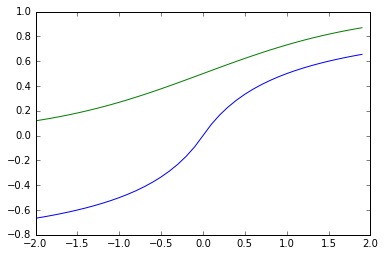

In [101]:

x = np.arange(-2,2,0.1)
y = fast_sigmoid(x)
y2 = 1 / (1 + np.exp(-x))
plt.plot(x,y)
plt.plot(x,y2)
plt.show()

In [10]:
gens = 1000
threshold = 0.1

inputs = [[1,1],[0,1],[1,0],[0,0]]
outputs = np.array([[1,-1,-1,-1]]).T

genome = Perceptron.random(2,1,activation=fast_sigmoid,maxdelta=0.1)
genome = Perceptron([[1.8],[1.8]],[[-3.0]],activation=fast_sigmoid)
learningfunc = MutationLearning(inputs,outputs,genome)


/Users/richardboyd/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:112: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


ValueError: shapes (12,) and (2,1) not aligned: 12 (dim 0) != 2 (dim 0)

In [84]:
genome.calcout(inputs)
print genome.matrix
print genome.offset

optimal = Perceptron([[2.0],[2.0]],[[-3.0]],activation=fast_sigmoid)
optimal.calcout(inputs)

out = optimal.calcout(inputs)
print inputs
print out
print outputs
error = np.array(outputs) - out
print error
average = np.sqrt((error**2).mean())
print average

[[ 1.8]
 [ 1.8]]
[[-3]]
[[1, 1], [0, 1], [1, 0], [0, 0]]
[[ 0.5 ]
 [-0.5 ]
 [-0.5 ]
 [-0.75]]
[[ 1]
 [-1]
 [-1]
 [-1]]
[[ 0.5 ]
 [-0.5 ]
 [-0.5 ]
 [-0.25]]
0.450693909433


In [85]:
maxdelta  = 0.01
# find change in max delta
dmaxdelta = optimal.maxdelta/100
# maxdelta changes up or down
optimal.maxdelta += dmaxdelta*random_sign()
size = np.size(optimal.matrix)
# make a copy of the matrix
nmatrix = np.copy(optimal.matrix)
print nmatrix
mutatematrix = np.random.binomial(1,0.33,(optimal.rows,optimal.columns))
delta = (np.random.rand(optimal.rows,optimal.columns)*2-1) * maxdelta
deltamatrix = mutatematrix * delta
print deltamatrix
nmatrix = nmatrix + deltamatrix
print optimal.__class__(nmatrix, optimal.offset, activation=optimal.activation, maxdelta=optimal.maxdelta)

[[ 2.]
 [ 2.]]
[[ 0.00622303]
 [-0.        ]]
Perceptron(matrix=array([[ 2.00622303],
       [ 2.        ]]), offset=array([[-3.]]), activation=<function fast_sigmoid at 0x10596ee60>, maxdelta=0.9216814801)


In [30]:

# output = self.calcout(XOPerceptron.trainingdata)
# error = np.array(goal) - output
# average = np.sqrt((error**2).mean())
# self.error = average
# return average

[[0 0 1 ..., 0 0 0]
 [1 1 0 ..., 1 0 0]
 [0 0 0 ..., 1 0 0]
 ..., 
 [0 0 1 ..., 0 1 0]
 [0 0 1 ..., 1 1 0]
 [0 0 0 ..., 1 0 1]]


In [73]:
optimal = Perceptron([[1.8],[1.8]],[[-3]],activation=fast_sigmoid)
optimal.calcout(inputs)

out = optimal.calcout(inputs)
print inputs
print out
print outputs
error = np.array(outputs) - out
print error
average = np.sqrt((error**2).mean())
print average

[[1, 1], [0, 1], [1, 0], [0, 0]]
[[ 0.375     ]
 [-0.54545455]
 [-0.54545455]
 [-0.75      ]]
[[ 1]
 [-1]
 [-1]
 [-1]]
[[ 0.625     ]
 [-0.45454545]
 [-0.45454545]
 [-0.25      ]]
0.465389122266


In [32]:
trainingdata = []

# def coach(board,side):
#     solution = False
#     while not solution:
#         play = randint(1,9)
#         trainingdata.append("".join(board))
#         if board[phonetoboard[play]] == ".":
#             solution = True
#     return play #phone
coach = oneturnai()

trainingdata = coach.trainingdata

for i in range(500):
    play_game(coach,stupidai, newboard())
    play_game(coach,oneturnai(), newboard())
    
trainingdata = trainingdata.items()
inputs = [data[0] for data in trainingdata]
moves = np.array([data[1] for data in trainingdata])
realgoal = [[0.5 if move == i else 0 for i in range(1,10)] for move in moves]
spec = inputs = [filter(lambda i: i != '\n', input) for input in inputs]
goal = np.array([[0.5 if bit == '.' else 0 for bit in input] for input in spec]) + realgoal
goal = [list(row) for row in goal]

def transboard(inputs,side,oside):
    inputs = filter(lambda i: i != '\n', inputs)
    side = [1 if bit == side else 0 for bit in inputs]
    oside = [1 if bit == oside else 0 for bit in inputs]
    space = [1 if bit == '.' else 0 for bit in inputs]
    return np.array(side+oside+space)


inputs = [list(transboard(input,'x','o')) for input in inputs]

print "inputs =", inputs
print "goal =", list(goal)

inputs = [[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0], [0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0], [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1], [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0], [0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0], [1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1], [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0], [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1